<a href="https://colab.research.google.com/github/ordevoir/Digital_Cathedra/blob/main/Data%20Analysis/clustering/sklearn_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Кластеризация
Кластеризация может быть использована для следующих задач:
- **анализ данных**: когда используется новый датасет может быть полезным запустить алгоритм кластеризации и затем анализировать каждый кластер по-отдельности
- **снижение размерности**: когда данные кластеризованы, обычно возможно измерить соотвествие (affinity) образца к каждому кластеру. Тогда вектор признаков $\mathbf x$ может быть представлен как вектор соответствия к кластерам. Размерность вектора будет равно числу кластеров. Такой вектор обычно существенно меньшей размерности, чем исходный вектор признаков, но при этом он может сохранять достаточно информации для следующей обработки.
- **обнаружение аномалий** (выбросов): каждый образец имеющий слабое соответствие ко всем кластерам вероятно представляет собой аномалию. Обнаружение аномалий в частности полезно в обнаружении деффектов в производстве или для обнаружения мошенничества.
- **частичное обучение с учителем** (*semi-supervised learning*): если имеется небольшой набор размеченных данных, и большой набор неразмеченных данных, можно произвести кластеризацию и распространить соответствующие метки на все образцы, находящиеся в одних и тех же кластерах. Такая техника может существенно повысить число размеченных данных для последующего обучения с учителем.
- **сегментация изображения**: кластеризуя пиксели в соответствии с их цветом, можно заменить цвет каждого пикселя средним цветом его кластера. Таким образом можно значительно уменьшить число различных цветов на изображении. Сегментация изображения используется во многих ситемах детекции и трекинга объекта, так как это упрощает детекцию контура каждого объекта.

Некоторые алгоритмы ищут экземпляры, сосредоточенные вокруг определенной точки, называемой центроидом. Другие ищут непрерывные области плотно упакованных экземпляров: такие кластеры могут принимать любую форму.

# Генерация данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Начнем с генерации кластеров/классов. Для этого можно воспользоваться функцией [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html).

In [17]:
from sklearn.datasets import make_blobs

# зададим центры кластеров:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])

# зададим среднеквадрадическое отклонение точек от центра:
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

`X` будет представлять собой массив точек:

In [27]:
print(X[:3])

[[-2.69823941  1.3454702 ]
 [-2.87459835  1.8097575 ]
 [ 0.96077126  1.17046777]]


`y` представляет собой массив соответствующих меток:

In [28]:
print(y[:3])
print(f"{y.min() = }\n{y.max() = }")

[4 2 0]
y.min() = 0
y.max() = 4


Функция для визуализации классов/кластеров:

In [39]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Визуализируем сгенерированные классы:

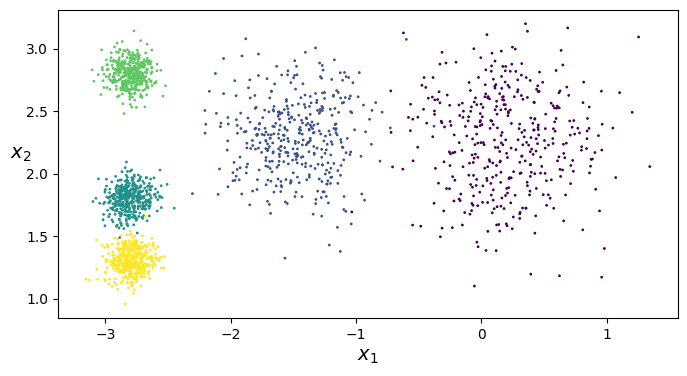

In [29]:
plt.figure(figsize=(8, 4))
plot_clusters(X, y)

Если игнорировать метки, то останется массив неразмеченных данных `X`. Будем использовать его для задачи кластеризации.

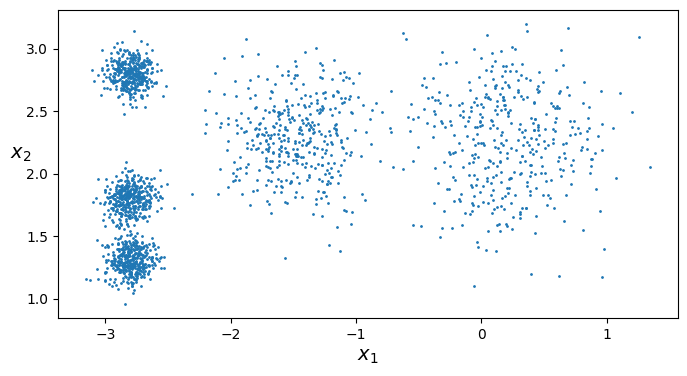

In [41]:
plt.figure(figsize=(8, 4))
plot_clusters(X)

## K-means вручную

[

In [ ]:
def euclid_distance(r1, r2):
    """Функция принимает два одномерых массива (вектора)
    Возвращает евклидово расстояние между векторами"""
    squares = (r1 - r2)**2
    distance = np.sqrt(squares.sum())
    return distance

def l1(r1, r2):
    """Функция принимает два одномерых массива (вектора)
    Возвращает расстояние городских кварталов между векторами"""
    return abs(r1-r2).sum() / len(r1)


def measure_distance(X, centroids, dist_function):
    """Функция принимает первым аргументом массив координат точек;
    вторым аргументом массив координат центров кластеров (центроидов)
    Возвращает массив расстояний до центров для каждой точки"""

    k = len(centroids)      # число кластеров
    n = len(X)              # число образцов

    # создаем массив, который будет содержать расстояния до центроидов
    distances = np.zeros((n, k))
    for i in range(n):
        # d будет содержать расстояния от точки до каждого из центроидов
        d = np.zeros(k)
        for j in range(k):
            d[j] = dist_function(X[i], centroids[j])
        distances[i] = d
    return distances

def correct_centroids(X, centroids, dist_function):
    """Функция принимает массив координат точек (образцов) и координаты
    центроидов кластеров (центроидов)
    Возвращает новые координаты центроидов """
    k = len(centroids)      # число кластеров
    distances = measure_distance(X, centroids, dist_function)
    instance_labels = distances.argmin(axis=1)      # метки образцов

    for i in range(k):
        X_i = X[instance_labels==i]

        centroid = X_i.mean(axis=0)
        # эта запись равносильна следующим трем строкам:
        # centroid = np.zeros(2)
        # centroid[0] = X_i[:, 0].mean()
        # centroid[2] = X_i[:, 0].mean()
        centroids[i] = centroid

    return centroids

Инициализация центроидов

In [ ]:
k = 5       # задаем число кластеров

# создаем рандомные координаты центров:
# np.random.seed(43)
init_centroids = np.random.uniform(low=(-3, 1), high=(0, 3),
                                   size=(k, 2))

# либо выбираем случайным образом из образцов:
# np.random.seed(40)
# random_indices = np.random.choice(len(X), size=5, replace=False)
# init_centroids = X[random_indices]

centroids = init_centroids.copy()
init_centroids

array([[-0.63046333,  1.99934808],
       [-0.95850304,  1.98749186],
       [-1.0221634 ,  2.3811597 ],
       [-0.67603324,  1.45404343],
       [-1.01865468,  2.96028526]])

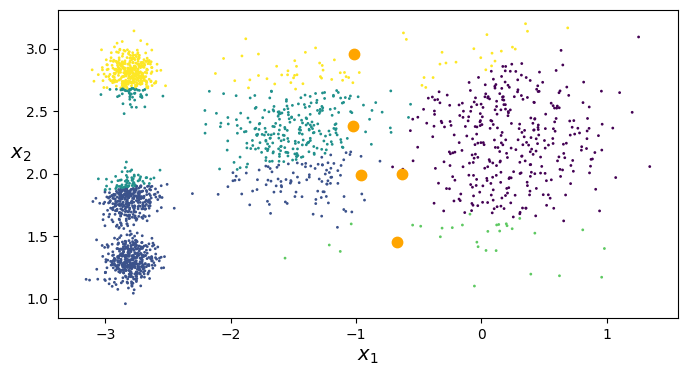

In [ ]:
labels = np.argmin(measure_distance(X, centroids, euclid_distance), axis=1)

plt.figure(figsize=(8, 4))
plot_clusters(X, labels)
plt.scatter(init_centroids[:, 0], init_centroids[:, 1], c='red', s=12)
plt.scatter(centroids[:, 0], centroids[:, 1], c='orange', s=56)

centroids = correct_centroids(X, centroids, euclid_distance)
# красные точки - исходные расположения центроидов
# оранжевые точки - результирующее расположение центроидов

## Класс KMeans из библиотеки Scikit-Learn
Метод `fit_predict()` производит кластеризацию данных и возвращает метки для образцов, соответствующие результату кластеризации. Кроме того объект класса `KMeans` сохраняет копию меток образцов, на которых происходило обучение, и они доступны в поле `labels_` объекта. Поле `cluster_centers_` содержит центры кластеров.

In [ ]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)
print(y_pred[:20]) # результат так же доступен через kmeans.labels_ :
print(y_pred is kmeans.labels_)
print(kmeans.cluster_centers_)

[4 1 0 1 1 4 1 1 2 1 1 1 1 4 1 4 3 2 3 0]
True
[[ 0.20876306  2.25551336]
 [-2.80389616  1.80117999]
 [-1.46679593  2.28585348]
 [-2.79290307  2.79641063]
 [-2.80037642  1.30082566]]


c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Спрогнозировать метки для новых образцов можно при помощи метода `predict()`.

In [ ]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
print(kmeans.predict(X_new))

[0 0 3 3]


Нарисуем диаграму Вороного и центроиды:

In [ ]:
# Нарисуем диаграму Вороного и центроиды:

def plot_data(X):
    plt.scatter(X[:, 0], X[:, 1], c='#444', s=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    # plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
    #             linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

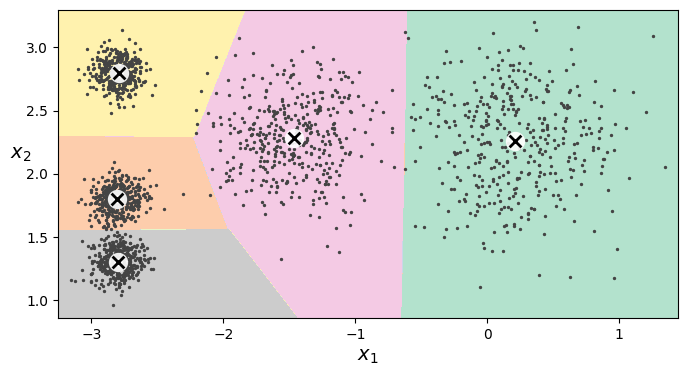

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Результат неплохой, но некоторые образцы вблизи границ все же кластеризованы некорректно.

### Hard and Soft Clustering
Если каждому образцу присваивается один кластер, то такой способ называется **жесткой кластеризацией** (*hard clustering*). Если же каждому образцу присваиватеся оценка по каждому кластеру, то это называется **мягкой кластеризацией** (*soft clustering*). Оценка может быть выражена расстоянием между образцом и центроидом. Методом `transform()` можно получить значения расстояний от этих образцов, до центроидов. Это можно использовать кроме всего прочего как очень эффективный, нелинейны способ снижения размерности: если бы у нас был многомерный датасет, такая трансформация свела бы его к $k$-мерному датасету.

In [ ]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

### Инициализация центроидов
Результат кластеризации зависит также от инициализации центроидов, и тут как повезет. Однако есть несколько способов снизить риск.

Вариант по умолчанию - запустить алгоритм несколько раз с различной инициализацией и сохранить лучшее решение. Именно за счет этого запуск модели класса KMeans дает обычно корректную кластеризацию, по сравнению с тем, что производилось вручную. Число случайных инициализайций контролируется гиперпараметром `n_init` (по умолчанию 10). Для того, чтобы выяснить, какое решение лучшее, используется метрика **инерция** (*inertia*), которая представляет собой сумму квадратов расстояний экземпляров до своих центроидов. В поле `inertia_` доступно итоговое (минимальное) значение этой метрики:

In [ ]:
print(kmeans.inertia_)
(kmeans.transform(X).min(axis=1) ** 2).sum()

211.59853725816836


211.5985372581688

Метод `score()` возвращает отрицательное значение инерции. Это связано с тем, что метод `score()` предиктора должен всегда соответствовать правилу "больше - значит лучше": если предиктор лучше другого предиктора, то метода `score()` должен возвращать большую оценку:

In [ ]:
kmeans.score(X)

-211.59853725816836

Если заранее известно, где примерно центроиды должны быть (например, из результатов другого алгоритма кластеризации), то можно задать эти центроиды в гиперпараметре `init`, установив при этом значение еще `n_init=1`:

In [ ]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

Алгоритм **K-Means++** предполагает умную инициализацию, которая склонна выбирать центроиды расположенные далеко друг от друга, что делает менее вероятным схождение к субоптимальным решением. Дополнительные вычисления, которые требубтся для этого существенно снижают число запусков алгоритма, которые требуются для нахождения оптимального решения. Этот метод инициализации используется по умолчанию в классе `KMeans`. Если нужно инициировать центроиды выбирая $k$ случайных образцов, следует задать `init="random"`.

### Mini-batch K-Means
Вместо того, чтобы использовать весь набора данных на каждой итерации, алгоритм способен использовать mini-batches, перемещая слегка центроиды на каждой итерации. Это обычно в несколько раз ускоряет алгоритм и позволяет кластеризовать огромные датасеты, которые не вмещаютя в память. Такой алгоритм реализован в классе `MiniBatchKMeans`.

Хотя Mini-batch K-means быстрее, чем обычный алгоритм K-Means, его инерция в целом несколько хуже, особенно с ростом числа кластеров.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans= MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)
minibatch_kmeans.inertia_

c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


223.76389619539268

### Поиск оптимального числа кластеров
В общем случае не так просто выяснить корректное число кластеров. Неудачный выбор числа кластеров может привести к плохому результату. Можно было бы подумать, что следует выбрать такое $k$, при котором достигается наименьшее значение инерции, но это не очень хорошая метрика, так как инерция обычно уменьшается с ростом числа кластеров.

In [ ]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)
kmeans_k3.fit(X)
kmeans_k8.fit(X)

c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=42)

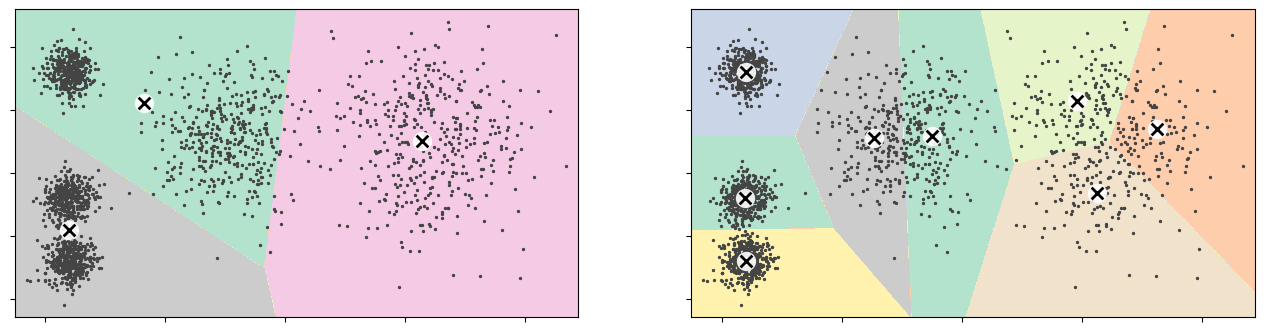

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(121)
plot_decision_boundaries(kmeans_k3, X, show_xlabels=False, show_ylabels=False)
plt.subplot(122)
plot_decision_boundaries(kmeans_k8, X, show_xlabels=False, show_ylabels=False)

In [ ]:
# инерция при трех различных значениях k
print(kmeans_k3.inertia_)
print(kmeans.inertia_)          # k = 5
print(kmeans_k8.inertia_)

653.2167190021554
211.59853725816836
119.11983416102879


### Зависимость инерции от числа кластеров

In [ ]:
kmeans_per_k = [KMeans(n_init=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

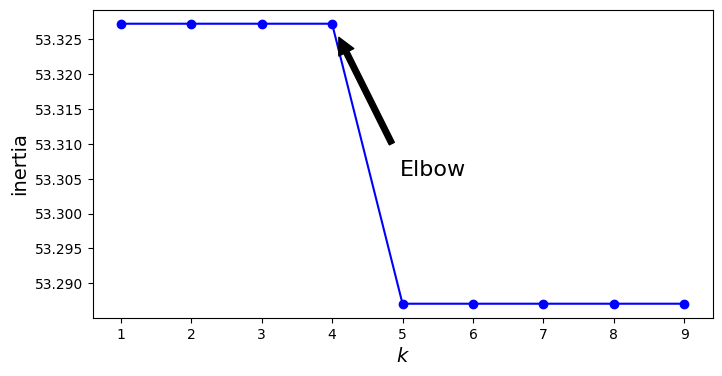

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.5, 0.5),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1),
             )
plt.show()

Глядя на график зависимости инерции от числа кластеров можно заметить, что инерция сначала быстро убывает, пока $k$ растет до 4, но затем это убывание становится существенно медленне с ростом $k$. Кривая отдаленно напоминает форму руки, где локоть (*elbow*) распологается около $k = 4$. Такая точка обычно является хорошим выбором при поиске оптимального значения $k$, ведь левее этой отметки инерция очень высокая, а правее она не очень то и убывает. Конечно, такой метод не гарантирует, что будет выбрано самое оптимальное значение $k$ (мы знаем, что в данном примере оптимальным значением является 5), но все получаемое значение будет хорошим. Посмотрим на результат кластеризации при $k=4$ и убедимся, что разбиение точек весьма удачное.

c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


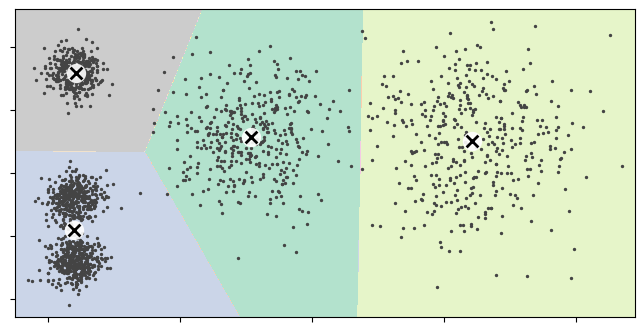

In [ ]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42)
kmeans_k4.fit(X)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_k4, X, show_xlabels=False, show_ylabels=False)

### Ограничения K-Means
Недостатками K-Means являются необходимость запускать алгоритм несколько раз во избежание субоптимальных решений, необходимость задавать число кластеров (что может быть довольно хлопотно). Более того K-Means не ведет себя очень хорошо, когда кластеры имеют различные размеры, различную плотность и имеют несферическую форму.

Создадим данные, содержащие кластеры несферической формы и разные плотноности, чтобы испытать на них алгоритм K-Means.

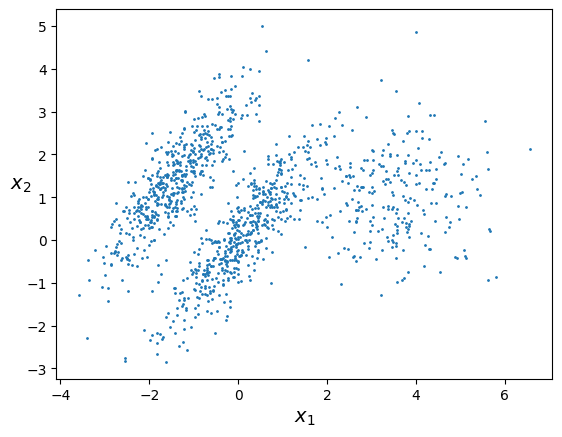

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_clusters(X)

In [ ]:
kmeans_good = KMeans(n_clusters=3, n_init=1, random_state=42,
                     init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]])
                     )
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

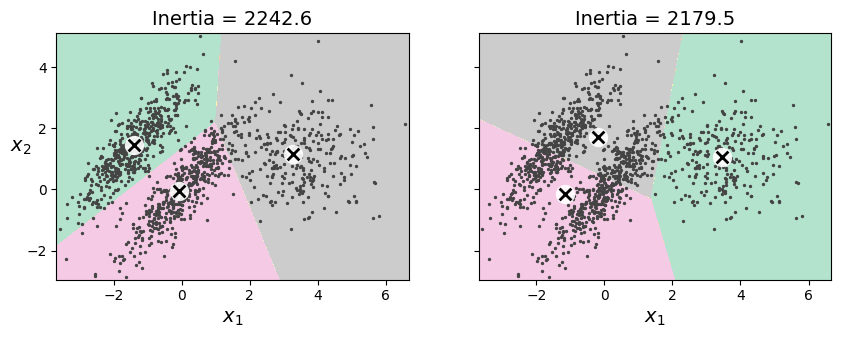

In [ ]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title(f"Inertia = {kmeans_good.inertia_:.1f}", fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title(f"Inertia = {kmeans_bad.inertia_:.1f}", fontsize=14)

plt.show()

Как можно видеть ни одно из решений не является хорошим. Решение на левой картинке лучше, но все же 25% точек кластера расположенного посередине были отнесены к кластеру, расположенному справа. Решение на правой картинке и вовсе никуда не годится, хотя значение инерции при этом лучше. На такого рода эллиптических кластерах Gaussian mixture models работает прекрасно.

Важно предварительно масштабировать признаки перед запуском K-Means, иначе кластеры могут быть очень растянуты и K-Means будет даст плохой результат. Масштабирование признаков не гарантирует, что все кластеры будут хорошими и сферическими, но обычно это улучшает дело.

## Использование кластеризации для сегментации изображения
Сегментация изображения (*image segmentation*) это задача разбиения изображения на множество сегментов. При **семантической сегментации** все пиксели относящиеся к одному и тому же объекту назначаются одному сегменту. Произведем **цветовую сегментацию** (*color segmentation*): будем назначать пиксели одному сегменту, если они имеют похожие цвета. В некоторых приложениях это может быть полезным. Например, если вы хотите анализировать спутниковые снимки и измерять, как много лесистой площади в регионе, цветовая сегментация может пригодиться.

Первым делом воспользуемся функцией `imread()` из библиотеки Matplotlib для загрузки изображения. Функция вернет трехмерный массив Numpy, который содержит значения цветовых каналов (RGB) пикселей картинки.

In [ ]:
from matplotlib.image import imread
image = imread("example.jpg")
image = imread("field_2.jpg")
print(type(image))
print(image.shape)          # (высота, ширина, количество каналов)
image.min(), image.max()    # минимальное и максимльное значения

<class 'numpy.ndarray'>
(533, 800, 3)


(0, 255)

(-0.5, 799.5, 532.5, -0.5)

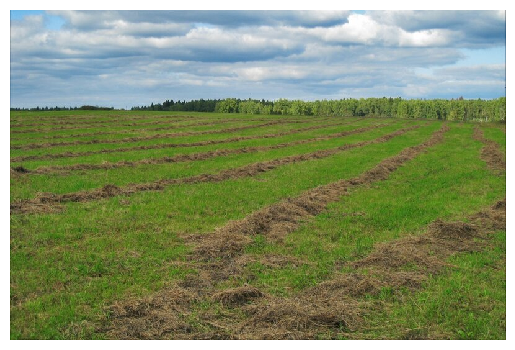

In [ ]:
plt.imshow(image, interpolation='none')
plt.axis('off')

(426400, 3)


c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


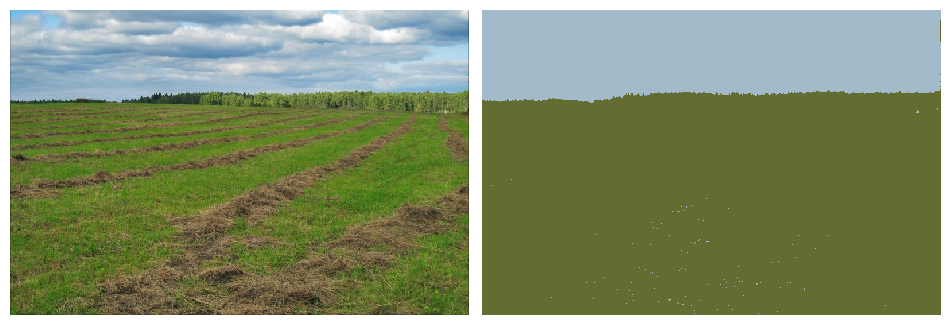

In [ ]:
from sklearn.cluster import KMeans
# reshape для того, чтобы линеаризировать матрицу пикселей
k = 2
X = image.reshape(-1, 3)
print(X.shape)
kmeans = KMeans(n_clusters=k).fit(X)   # разбиваем точки на класстеры

# формируем матрицу, соответствующую форме матрицы X:
segmentedImg = kmeans.cluster_centers_[kmeans.labels_]
# reshape, чтобы представить точки обратно в двухмерном виде
segmentedImg = segmentedImg.reshape(image.shape)

# нарисуем результат
segmentedImg = segmentedImg / 255

plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.03)

plt.subplot(121)
plt.imshow(image, interpolation='none')
plt.axis('off')

plt.subplot(122)
plt.imshow(segmentedImg, interpolation='none')
plt.axis('off')
plt.show()

## DBSCAN
Алгоритм кластеризации DBSCAN (Density-Based Spatial Clustering of Applications with Noise) основан на оценке локальной плотности и работет по следующему принципу:
- Для каждого образца алгоритм подсчитывает число образцов, находящихся в его окрестности (*neighborhood*) на расстоянии, не превыщающем некоторого значения $\varepsilon$ (это называется $\varepsilon$-окрестностью).
- Если образец содержит в своей $\varepsilon$-окрестности не менее `min_samples` образцов, то такой образец считается **центральным** (*core instance*). Другими словами, центральным является такой образец, который расположен в плотной области.
- Все образцы в окрестности центрального образца принадлежат одному кластеру. Такая окрестность может содержать и другие центральные образцы, так что длинная последовательность соседствующих центральных образцов формируют один кластер.
- Всякий образец, который не является центральным и не содержит в своей $\varepsilon$-окрестности ни одного центрального образца, считается аномалией.

Алгоритм работает хорошо, если все кластеры достаточно плотные и хорошо разделены областями низкой плотности.

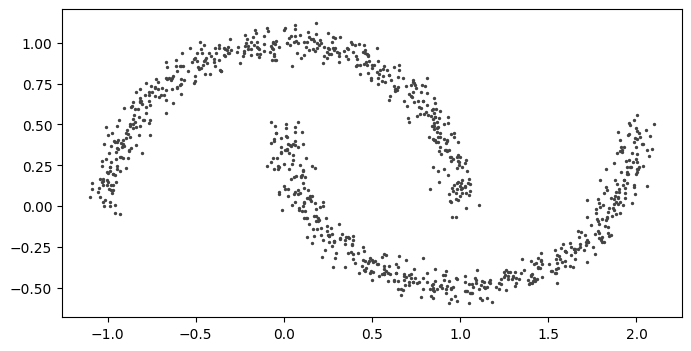

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05)
plt.figure(figsize=(8, 4))
plot_data(X)

Вот как справляется с такими данными алгоритм K-Means:

c:\Users\wernadsky\miniconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


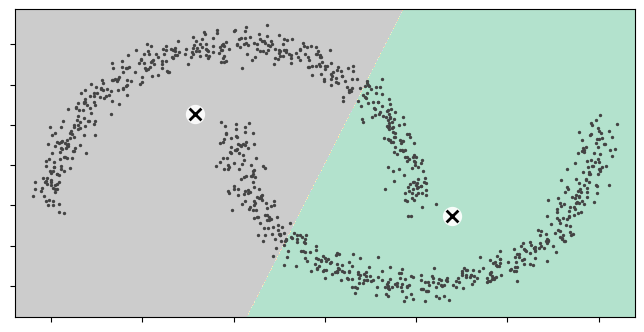

In [ ]:
kmeans_k2 = KMeans(n_clusters=2, random_state=42)
kmeans_k2.fit(X)
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_k2, X, show_xlabels=False, show_ylabels=False)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

Метки (кластерные индексы) для всех образцов доступны в поле `labels_`. Некоторые образцы имеют кластерный индекс -1. Такие метки соответствуют аномалиям. Индексы центральных образцов доступны вполе `core_sample_indices_`, а сами образцы доступны в поле `components_`.

In [ ]:
dbscan.labels_[:12]

array([ 0,  1,  1,  1,  1,  2,  2,  0,  1,  1,  8, -1], dtype=int64)

In [ ]:
print(dbscan.core_sample_indices_[:20])
len(dbscan.core_sample_indices_)

[ 0  1  2  3  5  6  8  9 12 13 14 15 17 18 19 20 21 23 24 25]


784

In [ ]:
dbscan.components_[:5]

array([[-0.89220031,  0.46504899],
       [ 0.0614573 ,  0.3757379 ],
       [ 1.22059078, -0.46844459],
       [ 1.2723576 , -0.40272123],
       [ 0.55907133,  0.76610533]])

In [ ]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

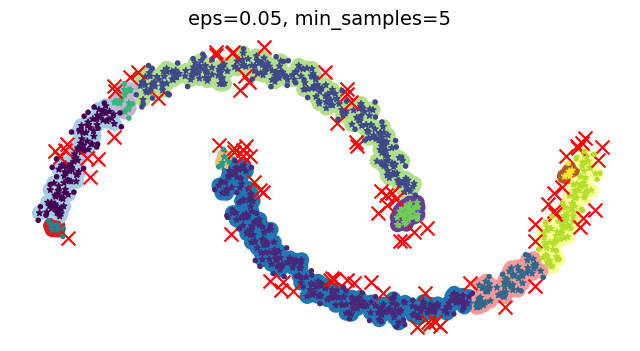

In [ ]:
plt.figure(figsize=(8, 4))
plt.axis(False)
plot_dbscan(dbscan, X, 100)

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

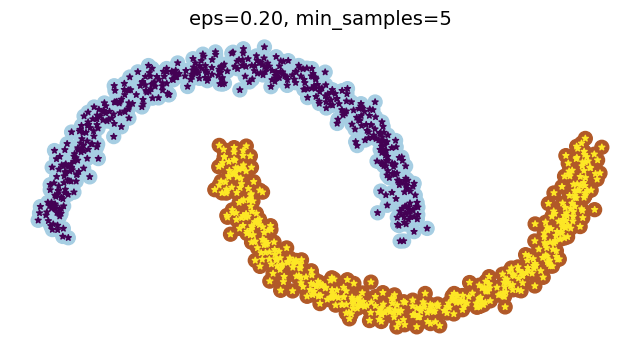

In [ ]:
plt.figure(figsize=(8, 4))
plt.axis(False)
plot_dbscan(dbscan2, X, 100)